# Exploratory data analysis carried out as one of the project stages for an Artificial Intelligence methods class

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import pandas as pd
import xml.etree.ElementTree as ET
from matplotlib.patches import Rectangle
from collections import Counter
import seaborn as sns
from roboflow import Roboflow
import opendatasets as od

In [3]:
from keys import api_key_roboflow

## Downloading of datasets

two datasets will be used, one from roboflow and one from kaggle

In [4]:
rf = Roboflow(api_key=api_key_roboflow)
project = rf.workspace("mohamed-attia-e2mor").project("pill-detection-llp4r")
dataset = project.version(1).download("voc")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pill-Detection-1 in voc:: 100%|██████████| 905/905 [00:00<00:00, 915.78it/s] 


In [5]:
od.download(
    "https://www.kaggle.com/datasets/perfect9015/pillsdetectiondataset")

Skipping, found downloaded files in ".\pillsdetectiondataset" (use force=True to force download)


moving all images into single directory for easier access in the future

In [6]:
for (dirpath, dirnames, filenames) in os.walk("Pill-Detection-1"):
  for filename in filenames:
    if os.path.join(dirpath,filename).lower().endswith(('.png', '.jpg', '.jpeg')):
      os.replace(os.path.join(dirpath,filename), "pillsdetectiondataset/pillsPicture/images/"+filename)
    if os.path.join(dirpath,filename).lower().endswith('.xml'):
      os.replace(os.path.join(dirpath,filename), "pillsdetectiondataset/pillsPicture/annotations/"+filename)

creating list of paths for both images and their corresponding annotations

In [21]:
img_list = []
ann_list = []
for (dirpath, dirnames, filenames) in os.walk("pillsdetectiondataset/pillsPicture/images"):
    for i, filename in enumerate(filenames):
      img_list.append(os.path.join(dirpath, filename))

for (dirpath, dirnames, filenames) in os.walk("pillsdetectiondataset/pillsPicture/annotations"):
    for i, filename in enumerate(filenames):
      ann_list.append(os.path.join(dirpath, filename))

img_list.sort()
ann_list.sort()

for i in range(3):
  print(f'Path to image: {img_list[i]},\nPath to annotation: {ann_list[i]}\n')

print(f'Num of images: {len(img_list)}')

Path to image: pillsdetectiondataset/pillsPicture/images\20210702_160947_jpg.rf.0f2bb7c90c25859d86e1c85cea7496ec.jpg,
Path to annotation: pillsdetectiondataset/pillsPicture/annotations\20210702_160947_jpg.rf.0f2bb7c90c25859d86e1c85cea7496ec.xml

Path to image: pillsdetectiondataset/pillsPicture/images\20210702_160950_jpg.rf.7b645ec7b162bbf9ed1e845ca6627666.jpg,
Path to annotation: pillsdetectiondataset/pillsPicture/annotations\20210702_160950_jpg.rf.7b645ec7b162bbf9ed1e845ca6627666.xml

Path to image: pillsdetectiondataset/pillsPicture/images\20210702_161003_jpg.rf.6a7de1c145dff9023fa91707c970cd5c.jpg,
Path to annotation: pillsdetectiondataset/pillsPicture/annotations\20210702_161003_jpg.rf.6a7de1c145dff9023fa91707c970cd5c.xml

Num of images: 602


Functions

In [23]:
def get_bboxes(path_to_ann): #function to extract coordinates from an xml file
  tree = ET.parse(path_to_ann)
  root = tree.getroot()

  annotations = []

  for bndbox in root.iter('bndbox'):
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    annotations.append([xmin, ymin, xmax, ymax])
  return annotations

def create_rectangle(bbox, linewidth, edgecolor): #function to produce a rectangle to be drawn 
  x = bbox[0]
  y = bbox[1]
  width = bbox[2]-bbox[0]
  height = bbox[3]-bbox[1]
  rect = Rectangle((x, y),width,height,linewidth=linewidth,edgecolor=edgecolor,facecolor='none')
  return rect
  

Plotting n images with bboxes; checking that everything is ok

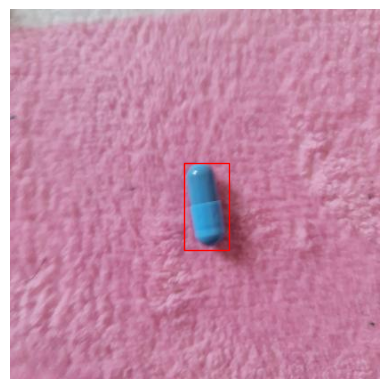

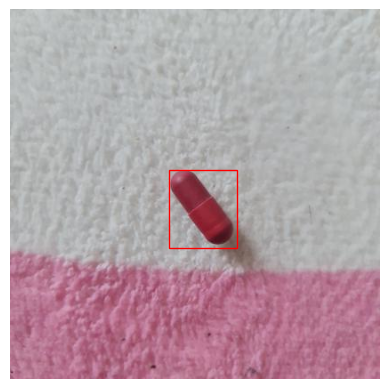

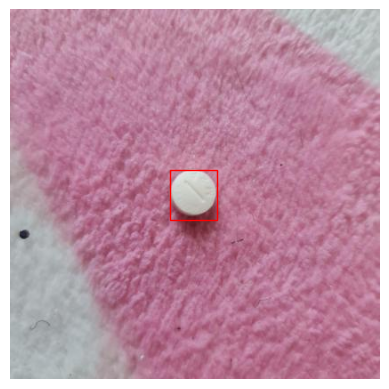

In [24]:
n = 3
for i in range(n):
  img =  np.asarray(Image.open(img_list[i]))
  bboxes = get_bboxes(ann_list[i])
  plt.imshow(img)
  ax = plt.gca()

  for bbox in bboxes:
    rect = create_rectangle(bbox, linewidth=1, edgecolor='r')
    ax.add_patch(rect)

  plt.axis('off')
  plt.show()

## statistics

The statistics selected are:
* size of images
* placement of bounding boxes
* size of boundingboxes
* number of bounding boxes per image

Functions

In [26]:
def bbox_size(coordinates): #function that calculates the width and height of bbox based on coordinates
  x_min, y_min, x_max, y_max = coordinates
  width = x_max-x_min
  height = y_max-y_min
  return width, height

def bbox_center_relative(bbox_coordinates, img_shape): #function that returns the centre of the bbox relative to the image size
  bbox_w, bbox_h = bbox_size(bbox_coordinates)
  img_h, img_w, _ = img_shape
  return (bbox_coordinates[0]+bbox_w/2.)/img_w, (bbox_coordinates[1]+bbox_h/2.)/img_h

Calculation of all values to be used for visualisation

In [27]:
shapes= []
centers = []
bbox_sizes = []
num_of_bboxes_per_image = []

for image, ann in zip(img_list, ann_list):
  img =  np.asarray(Image.open(image))
  shapes.append((np.shape(img)))

  bboxes = get_bboxes(ann)
  num_of_bboxes_per_image.append(len(bboxes))
  for bbox in bboxes:
    centers.append(bbox_center_relative(bbox, np.shape(img)))
    bbox_sizes.append(bbox_size(bbox))

shapes_counter  = Counter(shapes)
num_of_bboxes_counter = Counter(num_of_bboxes_per_image)

Plotting

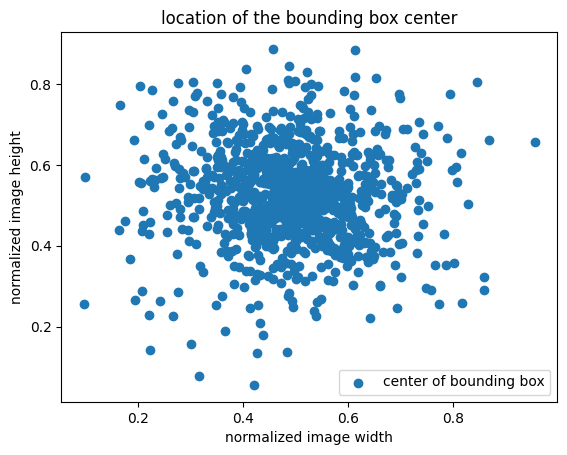

In [13]:
plt.scatter(*zip(*centers), label='center of bounding box')
plt.xlabel('normalized image width')
plt.ylabel('normalized image height')
plt.legend()
plt.title('location of the bounding box center')
plt.show()

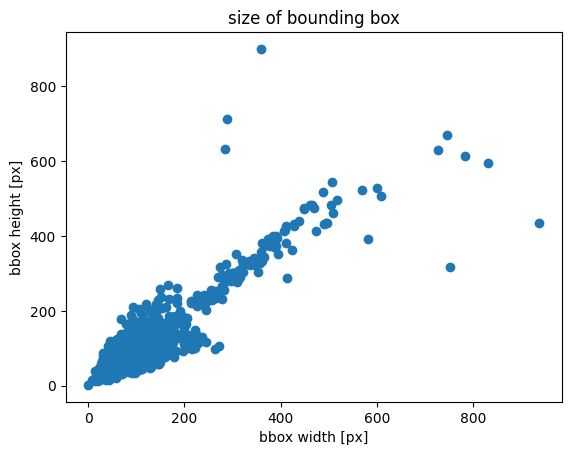

In [14]:
plt.scatter(*zip(*bbox_sizes))
plt.xlabel('bbox width [px]')
plt.ylabel('bbox height [px]')
plt.title('size of bounding box')
plt.show()

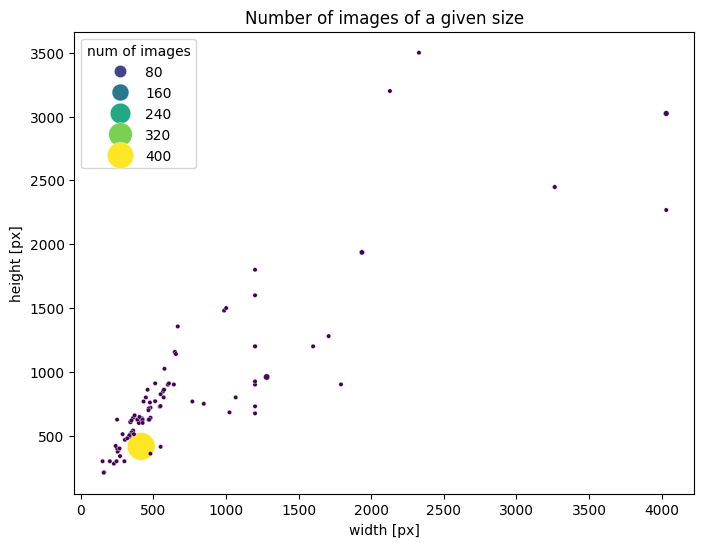

In [15]:
x = []
y = []
for key in shapes_counter.keys():
  x.append(key[0])
  y.append(key[1])

d = {'width': x, 'height': y, 'num of images': shapes_counter.values()}
df = pd.DataFrame(data=d)

hue_order = list(shapes_counter.values())
hue_order.sort()
sns.scatterplot(data=df, x='width',y='height', hue='num of images', size='num of images', sizes=(10,400), hue_norm=(0, 400), palette='viridis')
plt.title('Number of images of a given size')
plt.xlabel('width [px]')
plt.ylabel('height [px]')
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()


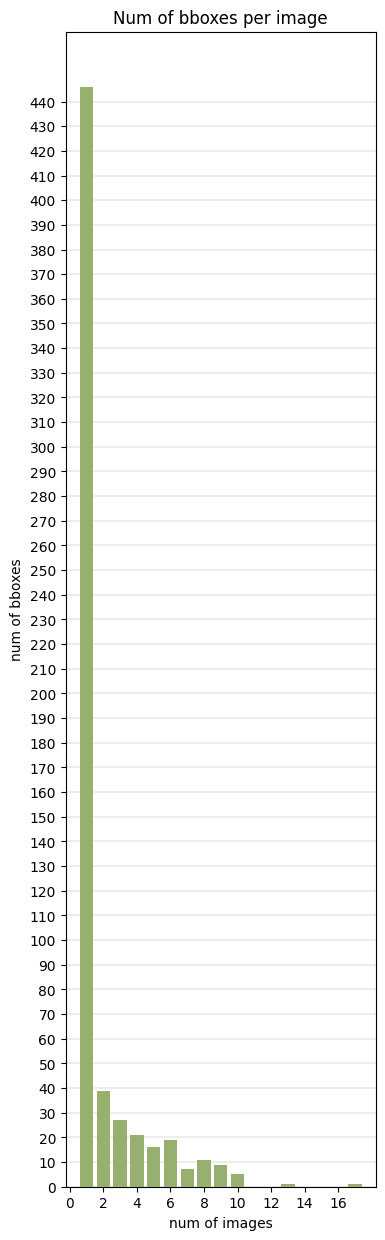

In [35]:
plt.bar(num_of_bboxes_counter.keys(), num_of_bboxes_counter.values(), color='#98B06F', zorder=3)
plt.xlabel('num of images')
plt.ylabel('num of bboxes')
plt.xticks(np.arange(0, max(num_of_bboxes_counter.keys())+1, step=2))
plt.yticks(np.arange(0, max(num_of_bboxes_counter.values())+1, step=10))
plt.title('Num of bboxes per image')

fig = plt.gcf()
plt.grid(axis='y', color='grey', linewidth=0.2, zorder=0)
fig.set_size_inches(4,15)